In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Loading Data Set

## Pre-Processing (Removing Non-Useful Information; refer to [MS3](https://github.com/balexdalex42/CSE151A-Group-Project-Gordon-Yang-Nafi-Mahbub-Alex-Tatoian-/tree/Milestone3))

In [2]:
final_df = pd.read_csv('./archive/prep_dataset.csv')

## Starting Unsupervised Learning

### Dropping Output Feature; Not Used for Unsupervised Learning



In [3]:
X = final_df.drop(columns=['pha'])
y = (final_df['pha'] == 'Y').astype(int)

In [4]:
# Encode the columns using one-hot
X = pd.get_dummies(X, drop_first=True)

In [5]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [6]:
# Try a 2D PCA and visualize it
pca2d = PCA(n_components=2)
X_pca2d = pca2d.fit_transform(X_sc)

In [7]:
X_pca2d.shape

(932335, 2)

In [8]:
import seaborn as sns

In [9]:
pca_vis_df = pd.DataFrame({
    'PCA1' : X_pca2d[:,0],
    'PCA2' : X_pca2d[:,1],
    'pha' : y
})

Text(0.5, 1.0, 'Asteroid Dataset Principle Component Analysis (dims=2)')

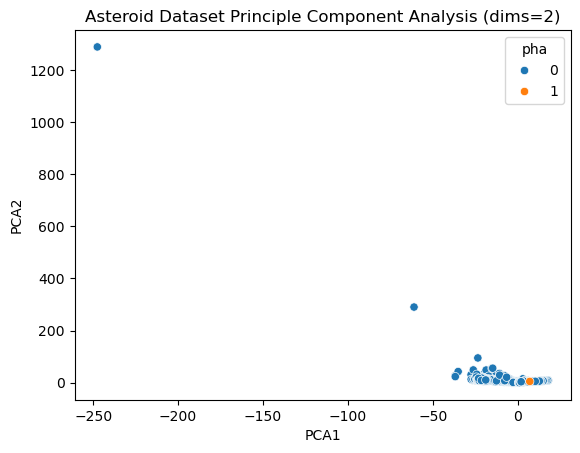

In [10]:
sns.scatterplot(data=pca_vis_df, x='PCA1', y='PCA2', hue='pha')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Asteroid Dataset Principle Component Analysis (dims=2)')

In [11]:
# Let's reduce our data to 5 features
svd5 = TruncatedSVD(n_components=5)
X5 = svd5.fit_transform(X)

In [12]:
svd5.explained_variance_ratio_

array([7.76368763e-06, 9.99992044e-01, 1.86340022e-07, 2.22223697e-09,
       1.96665580e-09])

In [13]:
svd5.singular_values_

array([3.35769092e+09, 2.26055961e+09, 9.75820752e+05, 1.06564400e+05,
       1.00249251e+05])

In [14]:
X5.shape

(932335, 5)

In [15]:
pca5 = PCA(n_components=5)
X_pca5 = pca5.fit_transform(X)

In [16]:
pca5.explained_variance_ratio_

array([9.99999468e-01, 4.65266085e-07, 6.05823629e-08, 2.22223652e-09,
       1.96657338e-09])

In [17]:
pca5.singular_values_

array([2.26056419e+09, 1.54194065e+06, 5.56403770e+05, 1.06564389e+05,
       1.00247151e+05])

In [18]:
pca5.feature_names_in_

array(['H', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'tp',
       'per', 'moid', 'rms', 'neo_Y', 'class_APO', 'class_AST',
       'class_ATE', 'class_CEN', 'class_IEO', 'class_IMB', 'class_MBA',
       'class_MCA', 'class_OMB', 'class_TJN', 'class_TNO'], dtype=object)

## Model Training (Using KNN)

### Splitting the Data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"x_train shape: {X_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (745868, 27)
x_test shape: (186467, 27)
y_train shape: (745868,)
y_test shape: (186467,)


### Getting the SVD of our Training Matrix

In [20]:
#training
scaler = StandardScaler()
X_sc_train = scaler.fit_transform(X_train)
U_train, S_train, V_train_t = np.linalg.svd(X_sc_train, full_matrices=False)
#Need centered testing matrix, note we use training mean though; NO DATA LEAKAGE ALLOWED
X_sc_test = scaler.transform(X_test)


In [21]:
#DEFINING CERTAIN CONSTANTS
max_num_neighbors = 15
#We know that we don't need to iterate to higher dim, since the dimensions would exp 95% of the var
variance_threshold = 0.05

In [22]:
#Now performing the Cross-Validation to get best k-value and number of neighbors
from sklearn.neighbors import KNeighborsClassifier

eigenvals = S_train**2
sum_eigenvalues = np.sum(S_train ** 2)
# explained_variance_ratio = (S_train ** 2) / sum_eigenvalues
# cum_var_ratio = np.cumsum(explained_variance_ratio) #will give us the cum_var_ratio for any k
# print(explained_variance_ratio)
# print(cum_var_ratio)
# k_min = np.argmax(cum_var_ratio >= variance_threshold) + 1 #will give us the min k val that meets threshold
# print(f"k_min: {k_min}")
#iterate over numbers of neighbors
best_macro_f1 = 0
best_k = 0
best_num_neighbors = 0
max_k = 6
best_cm = None

for k in range(1, max_k):
  U_k, S_k, Vt_k = U_train[:, :k], S_train[:k], V_train_t[:k, :]
  X_train_k = U_k @ np.diag(S_k) # could've used formula Xc_train @ Vt_k.T
  X_test_k = X_sc_test @ Vt_k.T
  for num_neighbors in range(1, max_num_neighbors + 1):
    knn = KNeighborsClassifier(n_neighbors=num_neighbors, n_jobs=-1)
    knn.fit(X_train_k, y_train)
    y_pred = knn.predict(X_test_k)
    report = classification_report(y_test, y_pred, output_dict=True)
    if report['macro avg']['f1-score'] > best_macro_f1:
      best_cm = confusion_matrix(y_test, y_pred)
      best_macro_f1 = report['macro avg']['f1-score']
      best_k = k
      best_num_neighbors = num_neighbors
print(f"best_k: {best_k}")
print(f"best_num_neighbors: {best_num_neighbors}")
print(f"best_macro_f1: {best_macro_f1}")

best_k: 5
best_num_neighbors: 3
best_macro_f1: 0.6779684071645421


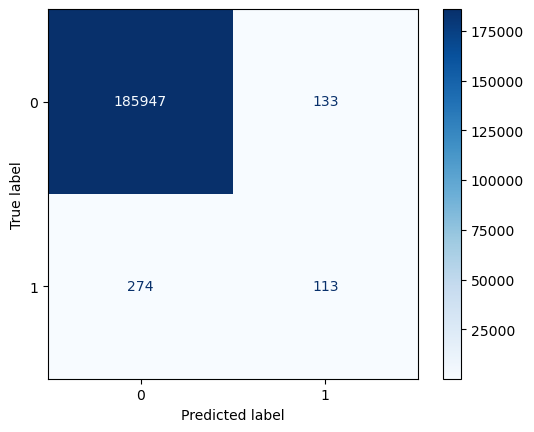

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()